# TD 1: Single Layer Perceptron


Goals: 
- check that everyone can run a notebook with appropriate config
- play around with the single-layer perceptron

Hédi Hadiji, 
with bits from Odalric Ambryn-Maillard.

December 2024

In [1]:
import os

# Empêche OpenMP / MKL de surcharger ton CPU -> évite les crashs
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"   # utile pour Windows
os.environ["KMP_INIT_AT_FORK"] = "FALSE"      # évite les crashs matplotlib

import torch

# Ces lignes doivent être exécutées AVANT que PyTorch démarre des threads
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

# Ensuite seulement tu peux importer numpy / matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [2]:

import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"



import time

import matplotlib.pyplot as plt

If necessary: install pytorch by running 

`pip3 install torch`

(in a a virtual environment)

In [70]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")

python --version = 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
torch.__version__ = 2.9.1+cpu
np.__version__ = 1.26.4


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [71]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print("zero_torch is of type {:s}".format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print("\nFloat:\n", zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print("Int:\n", zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print("Bool:\n", zero_torch_bool)

# Reshape
print("\nView new shape...", zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print("\nAlgebraic operations are overloaded:\n", a, "\n+\n", b, "\n=\n", a + b)

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[-1.5762, -1.1024],
        [ 0.0739,  0.6869],
        [ 0.4895, -1.3046]]) 
+
 tensor([[ 0.3704, -0.0201],
        [ 1.1445, -0.8876],
        [ 0.2011,  2.2007]]) 
=
 tensor([[-1.2057, -1.1225],
        [ 1.2184, -0.2007],
        [ 0.6906,  0.8961]])


### Gradient management

In [72]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to
# handle automatic differentiation (i.e keeping track of the gradient and which
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it.
# However when returning the result of training, do use detach() to save memory
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print("Initial guess:", theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()

    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2

    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()

    # Run one step of optimisation routine.
    optimizer.step()

print("Final estimate:", theta.detach())
print("The final estimate should be close to", y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([-2.3429])
Final estimate: tensor([2.0408])
The final estimate should be close to tensor([2.])


# Setting up a Perceptron experiment

### 1 - Data

In [73]:
class ToyLinearData:
    """
    Toy dataset generating linearly separable data with margin gamma.
    """

    def __init__(self, n, d, gamma=0, w=None):
        self.n = n
        self.d = d
        self.gamma = gamma
        if w is None:
            w = torch.normal(torch.zeros(d)) 
        self.w = w / torch.linalg.norm(w)

        self.features = torch.zeros((n, d))
        self.labels = torch.zeros((n))
        self.max_norm = 0
        self.w_margin = 1e10

        self.fill_data()

    def fill_data(self):
        for i in range(self.n):
            x, y = self.new_example()
            self.features[i, :] = x
            self.labels[i] = y
            self.max_norm = max(torch.norm(x), self.max_norm)
            self.w_margin = min(abs(torch.dot(self.w, x)), self.w_margin)

    def new_example(self):
        """
        Generates a gaussian vector with zero mean and identity / sqrt(d) covariance, then
        moves it in the direction of w or in the opposite direction, to guarantee margin.
        """
        # Gaussian vectors typically have norm around sqrt(d), so we normalise
        x = torch.normal(torch.zeros(self.d)) / np.sqrt(self.d)
        value = torch.dot(x, self.w)
        if value >= 0:
            x = x + self.gamma * self.w
            y = 1
        elif value < 0:
            x = x - self.gamma * self.w
            y = -1
        return x, y

    def __len__(self):
        return self.n


class ToySphericalData:
    """
    Generate toy data that is not linearly separable
    """

    def __init__(self, n, d, max_rad=1, threshold_rad=0.5):
        self.n = n
        self.d = d

        self.features = torch.zeros((n, d))
        self.labels = torch.zeros((n))

        self.max_rad = max_rad
        self.threshold_rad = threshold_rad

        self.fill_data()

    def fill_data(self):
        for i in range(self.n):
            r = np.random.rand() * self.max_rad
            x = torch.normal(torch.zeros(d))
            x = r / torch.norm(x) * x
            self.features[i, :] = x
            if r > self.threshold_rad:
                self.labels[i] = 1
            else:
                self.labels[i] = -1

    def __len__(self):
        return self.n


def plot_data(data):
    "Scatter plot for d = 2. Quite slow"
    for i in range(len(data)):
        if data.labels[i] == 1:
            plt.scatter(
                data.features[i][0], data.features[i][1], color="blue"
            )  # , label='+1')
        else:
            plt.scatter(
                data.features[i][0], data.features[i][1], color="red"
            )  # , label='-1')


Margin of w :  0.0029
Max norm :  2.7849
True w : tensor([0.9056, 0.4241])


(-2.449325942993164,
 2.1469172477722167,
 -2.9987532436847686,
 1.8215134680271148)

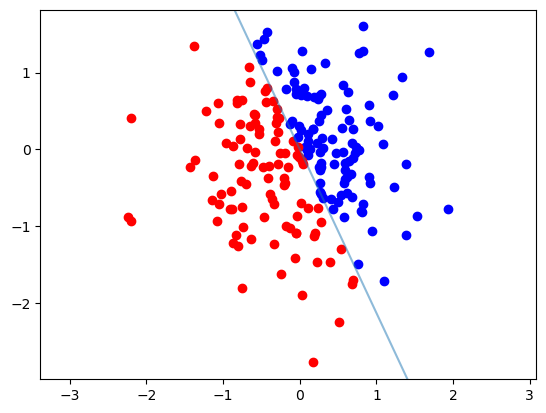

In [74]:
n = 200
d = 2
gamma = 0
data = ToyLinearData(n, d, gamma=gamma)
print(f"Margin of w : {data.w_margin: .4f}")
print(f"Max norm : {data.max_norm: .4f}")
print(f"True w : {data.w}")

plot_data(data)

plt.axline(
    (0, 0), slope=-data.w[0] / data.w[1], color="C0", alpha=0.5, label="True Hyperplane"
)

plt.axis("equal")


(-1.0562491595745087,
 1.0648572623729706,
 -1.0474686712026595,
 1.0882244795560836)

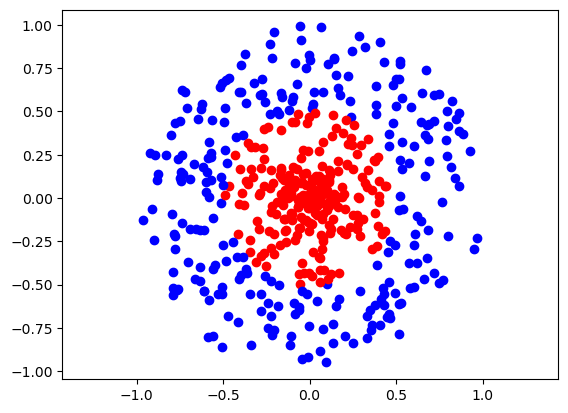

In [75]:
n = 500
d = 2
data = ToySphericalData(n, d)

plot_data(data)

plt.axis("equal")

## 2 - Implementing the Perceptron

In [76]:
class Perceptron:
    """
    Single-layer Perceptron
    """

    def __init__(self, dim):
        self.dim = dim
        self.w = torch.zeros(dim)

        self.margin_mistake_counter = 0

    def predict(self, x):
        if torch.dot(self.w, x) > 0:
            return 1
        else:
            return -1

    def update_margin_mistake(self, x, y):
        self.w += y * x
        self.margin_mistake_counter += 1

In [77]:
def train_perceptron(alg, data, t_lim=100_000):
    converged = False
    t = 0
    while not (converged) and t < t_lim:
        shuffled_indices = np.arange(len(data))
        # np.random.shuffle(shuffled_indices)
        clean_pass = True
        for i in shuffled_indices:
            x, y = data.features[i], data.labels[i]
            if torch.dot(alg.w, x) * y < 1:
                alg.update_margin_mistake(x, y)
                clean_pass = False
            t += 1
        if clean_pass:
            converged = True
    return converged

In [78]:
n = 100
d = 2
gamma = 0.5
data = ToyLinearData(n, d, gamma=gamma)
alg = Perceptron(d)


# 3 - Testing the Perceptron

In [79]:
n = 20
d = 2
gamma = 0.1
data = ToyLinearData(n, d, gamma=gamma)
alg = Perceptron(d)

### Run the code below a few times to see how the Perceptron behaves.

You can restart and initialize the algorithm again by running the cell above.

Point selected leads to a margin mistake
Normalized Alg w : tensor([0.1074, 0.9942])
True w:  tensor([0.2512, 0.9679])


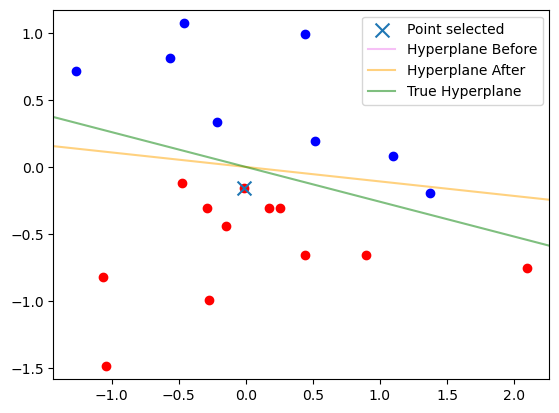

In [80]:
plot_data(data)

i = np.random.randint(len(data))
x, y = data.features[i], data.labels[i]
plt.scatter(x[0], x[1], marker="x", s=100, label="Point selected")

plt.axline(
    (0, 0),
    slope=-alg.w[0] / alg.w[1],
    color="violet",
    alpha=0.5,
    label="Hyperplane Before",
)

if torch.dot(alg.w, x) * y < 1:
    alg.update_margin_mistake(x, y)
    print("Point selected leads to a margin mistake")
else:
    print("Point selected is well classified with a margin: no update")

plt.axline(
    (0, 0),
    slope=-alg.w[0] / alg.w[1],
    color="orange",
    alpha=0.5,
    label="Hyperplane After",
)

plt.axline(
    (0, 0),
    slope=-data.w[0] / data.w[1],
    color="green",
    alpha=0.5,
    label="True Hyperplane",
)

print("Normalized Alg w :", alg.w / torch.norm(alg.w))
print("True w: ", data.w)

plt.legend()
plt.axis("equal")
plt.show()

### Non-separable data

In [81]:
n, d = 100, 2
data = ToySphericalData(n, d)

Point selected leads to a margin mistake
Alg w : tensor([-0.6850, -0.2097])


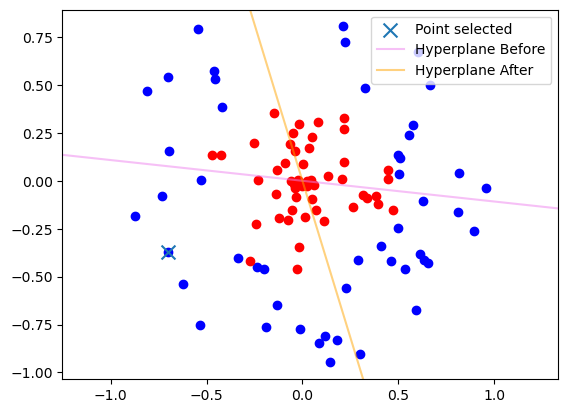

In [82]:
plot_data(data)

i = np.random.randint(len(data))
x, y = data.features[i], data.labels[i]
plt.scatter(x[0], x[1], marker="x", s=100, label="Point selected")

plt.axline(
    (0, 0),
    slope=-alg.w[0] / alg.w[1],
    color="violet",
    alpha=0.5,
    label="Hyperplane Before",
)

if torch.dot(alg.w, x) * y < 1:
    alg.update_margin_mistake(x, y)
    print("Point selected leads to a margin mistake")
else:
    print("Point selected is well classified with a margin: no update")

plt.axline(
    (0, 0),
    slope=-alg.w[0] / alg.w[1],
    color="orange",
    alpha=0.5,
    label="Hyperplane After",
)

print("Alg w :", alg.w)
# print('True w: ', data.w)

plt.legend()
plt.axis("equal")
plt.show()

### Just run the algorithm in higher dim to check

In [83]:
n, d, gamma = 1000, 30, 0
data = ToyLinearData(n, d, gamma=gamma)

alg = Perceptron(d)
converged = train_perceptron(alg, data, t_lim=1_000_000)
print(f"Converged: {converged}")

print(alg.w)
print(torch.norm(alg.w))
print(alg.w / torch.norm(alg.w))
print(data.w)
print(torch.norm(data.w - alg.w / torch.norm(alg.w)) / np.sqrt(d))

Converged: False
tensor([ 12.3221,  27.9244,   9.5868, -34.2456,  61.2347, -13.9806,  59.6453,
         38.1881,  -8.5284, -20.2929,  42.6049,  28.2147,  -0.3818, -30.9169,
         15.1148, -37.7642,   7.6577,   3.2826,  13.4612,  39.7590,  25.7139,
          1.0716,  36.2641,  50.0106,  -4.5494, -29.3507, 104.1626,  -8.4272,
         -6.6193, -40.1239])
tensor(191.3905)
tensor([ 0.0644,  0.1459,  0.0501, -0.1789,  0.3199, -0.0730,  0.3116,  0.1995,
        -0.0446, -0.1060,  0.2226,  0.1474, -0.0020, -0.1615,  0.0790, -0.1973,
         0.0400,  0.0172,  0.0703,  0.2077,  0.1344,  0.0056,  0.1895,  0.2613,
        -0.0238, -0.1534,  0.5442, -0.0440, -0.0346, -0.2096])
tensor([ 0.0412,  0.1635,  0.0585, -0.1722,  0.3136, -0.0796,  0.3151,  0.1930,
        -0.0605, -0.1001,  0.2199,  0.1716, -0.0067, -0.1471,  0.0887, -0.2194,
         0.0489,  0.0136,  0.0760,  0.1921,  0.1333, -0.0053,  0.1744,  0.2524,
        -0.0134, -0.1628,  0.5429, -0.0545, -0.0354, -0.2128])
tensor(0.0114)


In [84]:
n, d = 200, 10
data = ToySphericalData(n, d)

alg = Perceptron(d)
converged = train_perceptron(alg, data, t_lim=100_000)
print(f"Converged: {converged}")

print(alg.w / torch.norm(alg.w), torch.norm(alg.w))

Converged: False
tensor([ 0.1632,  0.2463, -0.0864,  0.0621, -0.0470,  0.6385,  0.4544,  0.4202,
         0.3209,  0.0739]) tensor(5.7490)


# 2 - Optimization of the Perceptron

In [85]:
ds = [100 * (i + 1) for i in range(20)]
n_ds = len(ds)
N_mc = 20
all_mistakes = np.zeros((n_ds, N_mc))

n = 1000
gamma = 0.1
norms = np.zeros((n_ds, N_mc))
margins = np.zeros((n_ds, N_mc))

all_converged = True

for i, d in enumerate(ds):
    for j in range(N_mc):
        data = ToyLinearData(n, d, gamma=gamma)
        alg = Perceptron(d)
        converged = train_perceptron(alg, data, t_lim=100_000)
        if not (converged):
            print("Perceptron did not converge")
        all_converged = converged and all_converged
        all_mistakes[i, j] = alg.margin_mistake_counter
        norms[i, j] = data.max_norm
        margins[i, j] = data.w_margin

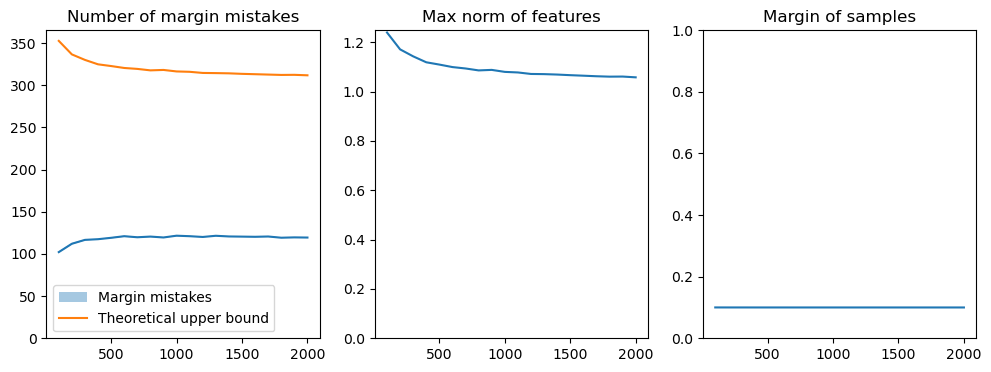

In [86]:
avg_mistakes = np.mean(all_mistakes, axis=1)
std_mistakes = np.std(all_mistakes, axis=1) / np.sqrt(N_mc)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plt.title("d varies")
axs[0].set_title("Number of margin mistakes")
axs[0].plot(ds, avg_mistakes)
axs[0].fill_between(
    ds,
    (avg_mistakes - std_mistakes),
    (avg_mistakes + std_mistakes),
    alpha=0.4,
    label="Margin mistakes",
)
mean_margins = np.mean(margins, axis=1)
axs[0].plot(
    ds,
    (2 + np.mean(norms, axis=1) ** 2) / mean_margins**2,
    label="Theoretical upper bound",
)
axs[0].set_ylim(0)
axs[0].legend()

axs[1].set_title("Max norm of features")
axs[1].plot(ds, np.mean(norms, axis=1))

axs[2].set_title("Margin of samples")
mean_margins = np.mean(margins, axis=1)
axs[2].plot(ds, mean_margins)

axs[1].set_ylim(0)
axs[2].set_ylim(0, max(1, max(mean_margins)))
plt.show()

# 2- Generalization

In [87]:
n = 10
d = 10
gamma = 0.1

data = ToyLinearData(n, d, gamma=gamma)
alg = Perceptron(d)
converged = train_perceptron(alg, data, t_lim=100_000)


In [88]:
def test(alg, data, N_test):
    """
    Generates a test set and returns the average
    error on this test set.
    """
    score = torch.zeros(N_test)
    for j in range(N_test):
        x, y = data.new_example()
        score[j] = alg.predict(x) * y
    return 1 - torch.mean(score)

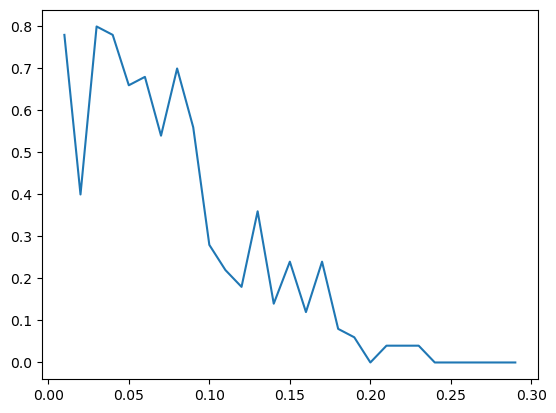

In [89]:
gammas = [0.01 * i for i in range(1, 30)]
n_train = 10
d = 50

n_gammas = len(gammas)
N_test = 100
errors = torch.zeros(n_gammas)

for i, gamma in enumerate(gammas):
    data = ToyLinearData(n_train, d, gamma=gamma)
    alg = Perceptron(d)
    converged = train_perceptron(alg, data, t_lim=1_000_000)
    if not (converged):
        print("Perceptron did not converge")
    errors[i] = test(alg, data, N_test)

plt.plot(np.array(gammas), errors)
plt.show()

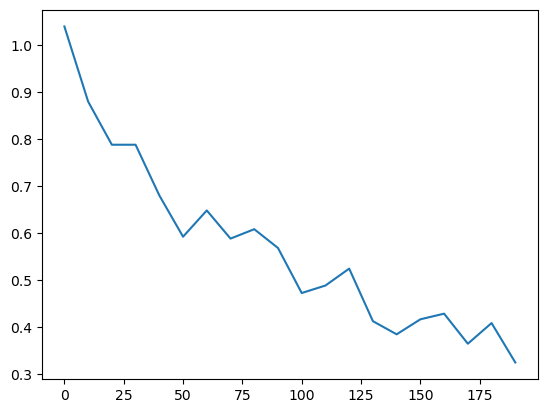

In [90]:
n_trains = [10 * i for i in range(20)]
d = 100

gamma = 0.0

number_of_trainings = len(n_trains)
N_test = 500
errors = torch.zeros(number_of_trainings)

for i, n_train in enumerate(n_trains):
    data = ToyLinearData(n_train, d, gamma=gamma)
    alg = Perceptron(d)
    converged = train_perceptron(alg, data, t_lim=1_000_000)
    if not (converged):
        print("Perceptron did not converge")

    errors[i] = test(alg, data, N_test)

plt.plot(n_trains, errors)